# Brunel Network (2000) — NEST Simulation

Based on *Dynamics of Sparsely Connected Networks of Excitatory and Inhibitory Spiking Neurons* (Brunel, 2000).


## 1. Introduction

This notebook implements and analyzes the Brunel (2000) spiking network model using the NEST simulator.

The model describes a sparsely connected population of Leaky Integrate-and-Fire (LIF) neurons driven by recurrent excitation, inhibition, and external Poisson input.

## 2. Network Schematic

![Brunel Network](../imgs/brunel_network.png)


## 3. Neuron Model (LIF)

The subthreshold voltage dynamics follow:

$$
\tau_m \frac{dV}{dt} = -V(t) + R I(t)
$$

A spike is emitted when:

$$
V(t) \geq V_{\text{th}}
$$

Then:

- the membrane voltage is reset:  
  $$ V \rightarrow V_{\text{reset}} $$
- refractory period is applied.

Typical parameters:

| Parameter | Value |
|----------|--------|
| Membrane time constant  20 ms |
| Threshold  | 20 mV |
| Reset | 10 mV |
| Refractory time \( \tau_{\text{ref}} \) | 2 ms |

---

## 4. Network Connectivity

### Populations

- \( N_E \) excitatory neurons  
- \( N_I \) inhibitory neurons  
- Sparsity:  
  $$ \epsilon = 0.1 $$

Each neuron receives:

- \( C_E = $\epsilon$ N_E \) excitatory connections  
- \( C_I = $\epsilon$ N_I \) inhibitory connections  

### Synaptic Weights

Excitatory synapses:

$$
J_exc
$$

Inhibitory synapses:

$$
J_in = -gJ_exc
$$

The parameter \( g \) controls the inhibitory-to-excitatory strength ratio and determines the dynamical regime.

### External Drive

All neurons receive Poisson input with rate:

$$
\nu_{\text{ext}}
$$

---

## 5. Brunel Dynamical Regimes
Depending on the values of g and $\nu_{\text{ext}}$, the network can exhibit different behaviors.

### Asynchronous Irregular (AI)

- high inhibition 
- irregular spiking  
- population does not synchronize  
- power spectrum is flat/broadband  

### Synchronous Irregular (SI)

- moderate inhibition  
- irregular bursts and partial synchrony  
- spectrum shows a broad low-frequency peak  

### Synchronous Regular (SR)

- weak inhibition
- high synchrony  
- regular oscillations  
- spectrum shows a sharp peak  

### Silent State

- external input too weak  
- activity stops  




In [1]:
# !pip install tqdm 

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import nest
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import welch, convolve
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.9.0
 Built: Oct  2 2025 07:08:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
nest.ResetKernel()

In [4]:
# Define the number of neurons
NE = 10000      # excitatory neurons 
NI = 2500      # inhibitory neurons 

In [5]:
# We want a sparse network --> sparse connectivity

epsilon = 0.1  # probability of connection

CE = int(epsilon * NE)
CI = int(epsilon * NI)

In [6]:
params = {
    "C_m": 250., 
    "tau_m": 20., 
    "tau_syn_ex": 0.5, 
    "tau_syn_in": 0.5,
    "t_ref": 2.0, 
    "E_L":0., 
    "V_reset": 10., 
    "V_m":0., 
    "V_th":20., 
}

In [7]:
# Create the two populations
E_neurons = nest.Create("iaf_psc_alpha", NE, params = params)
I_neurons = nest.Create("iaf_psc_alpha", NI, params = params)

In [8]:
poisson_rate = 18000.
poisson = nest.Create("poisson_generator", {"rate": poisson_rate})

In [9]:
J_exc = 20.
g = 5. # E/I ratio
J_in = -g*J_exc

In [10]:
# provide excitatory external input to both populations
nest.Connect(poisson, E_neurons, syn_spec={"weight": J_exc, "delay":1.5})
nest.Connect(poisson, I_neurons, syn_spec={"weight": J_exc, "delay":1.5})

In [11]:
# E->E connectivity
nest.Connect(E_neurons, E_neurons,
             conn_spec={'rule': 'fixed_indegree', 'indegree': CE},
             syn_spec={'weight': J_exc, 'delay':1.5})

# E->I connectivity
nest.Connect(E_neurons, I_neurons,
             conn_spec={'rule': 'fixed_indegree', 'indegree': CE},
             syn_spec={'weight': J_exc, 'delay':1.5})

# I->E connectivity
nest.Connect(I_neurons, E_neurons,
             conn_spec={'rule': 'fixed_indegree', 'indegree': CI},
             syn_spec={'weight': J_in, 'delay':1.5})

# I->I connectivity
nest.Connect(I_neurons, I_neurons,
             conn_spec={'rule': 'fixed_indegree', 'indegree': CI},
             syn_spec={'weight': J_in, 'delay':1.5})

In [12]:
spike_rec_E = nest.Create("spike_recorder")
spike_rec_I = nest.Create("spike_recorder")
nest.Connect(E_neurons[:1000], spike_rec_E) 
nest.Connect(I_neurons[:1000], spike_rec_I) 

In [13]:
T = 1000          
dt_chunk = 10     

for _ in tqdm(range(0, T, dt_chunk)):
    nest.Simulate(dt_chunk)

  2%|█▋                                                                                | 2/100 [00:01<00:54,  1.80it/s]


Nov 05 09:59:36 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:37 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:37 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:37 SimulationManager::run [Info]: 
    Simulation finished.


  3%|██▍                                                                               | 3/100 [00:01<00:40,  2.40it/s]


Nov 05 09:59:37 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:38 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:38 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.


  4%|███▎                                                                              | 4/100 [00:01<00:32,  2.98it/s]


Nov 05 09:59:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:38 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:38 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:38 SimulationManager::run [Info]: 
    Simulation finished.


  6%|████▉                                                                             | 6/100 [00:02<00:24,  3.82it/s]


Nov 05 09:59:38 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:38 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:38 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:38 SimulationManager::run [Info]: 
    Simulation finished.


  8%|██████▌                                                                           | 8/100 [00:02<00:21,  4.19it/s]


Nov 05 09:59:38 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:39 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:39 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.


 10%|████████                                                                         | 10/100 [00:02<00:20,  4.49it/s]


Nov 05 09:59:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:39 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:39 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:39 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:39 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:39 SimulationManager::run [Info]: 
    Simulation finished.


 13%|██████████▌                                                                      | 13/100 [00:03<00:20,  4.34it/s]


Nov 05 09:59:39 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:40 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:40 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:40 SimulationManager::run [Info]: 
    Simulation finished.


 14%|███████████▎                                                                     | 14/100 [00:03<00:19,  4.33it/s]


Nov 05 09:59:40 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:40 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:40 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:40 SimulationManager::run [Info]: 
    Simulation finished.


 16%|████████████▉                                                                    | 16/100 [00:04<00:18,  4.53it/s]


Nov 05 09:59:40 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:40 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:40 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:41 SimulationManager::run [Info]: 
    Simulation finished.


 19%|███████████████▍                                                                 | 19/100 [00:04<00:16,  4.78it/s]


Nov 05 09:59:41 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:41 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:41 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:41 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:41 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:41 SimulationManager::run [Info]: 

 23%|██████████████████▋                                                              | 23/100 [00:05<00:15,  4.91it/s]


Nov 05 09:59:41 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:41 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:41 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:42 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:42 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:42 SimulationManager::run [Info]: 

 24%|███████████████████▍                                                             | 24/100 [00:05<00:15,  4.91it/s]


Nov 05 09:59:42 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:42 SimulationManager::run [Info]: 
    Simulation finished.


 26%|█████████████████████                                                            | 26/100 [00:06<00:15,  4.70it/s]


Nov 05 09:59:42 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:42 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:42 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:43 SimulationManager::run [Info]: 
    Simulation finished.


 27%|█████████████████████▊                                                           | 27/100 [00:06<00:15,  4.72it/s]


Nov 05 09:59:43 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:43 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:43 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:43 SimulationManager::run [Info]: 
    Simulation finished.


 29%|███████████████████████▍                                                         | 29/100 [00:07<00:16,  4.26it/s]


Nov 05 09:59:43 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:43 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:43 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.


 32%|█████████████████████████▉                                                       | 32/100 [00:07<00:15,  4.41it/s]


Nov 05 09:59:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:44 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:44 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:44 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:44 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:44 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:44 NodeManager::prepare_nodes [Info]: 
    Preparing 12

 34%|███████████████████████████▌                                                     | 34/100 [00:08<00:15,  4.23it/s]


Nov 05 09:59:44 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:44 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:44 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:45 SimulationManager::run [Info]: 
    Simulation finished.


 36%|█████████████████████████████▏                                                   | 36/100 [00:08<00:14,  4.41it/s]


Nov 05 09:59:45 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:45 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:45 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.


 39%|███████████████████████████████▌                                                 | 39/100 [00:09<00:13,  4.63it/s]


Nov 05 09:59:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:45 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:45 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:45 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:45 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:45 SimulationManager::run [Info]: 
    Simulation finished.


 41%|█████████████████████████████████▏                                               | 41/100 [00:09<00:12,  4.65it/s]


Nov 05 09:59:45 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:46 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:46 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:46 SimulationManager::run [Info]: 
    Simulation finished.


 42%|██████████████████████████████████                                               | 42/100 [00:09<00:12,  4.73it/s]


Nov 05 09:59:46 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:46 SimulationManager::run [Info]: 
    Simulation finished.


 44%|███████████████████████████████████▋                                             | 44/100 [00:10<00:11,  4.73it/s]


Nov 05 09:59:46 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:46 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:46 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:47 SimulationManager::run [Info]: 
    Simulation finished.


 46%|█████████████████████████████████████▎                                           | 46/100 [00:10<00:10,  4.94it/s]


Nov 05 09:59:47 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:47 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:47 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:47 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:47 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:47 SimulationManager::run [Info]: 

 50%|████████████████████████████████████████▌                                        | 50/100 [00:11<00:10,  4.90it/s]


Nov 05 09:59:47 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:47 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:47 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:48 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:48 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:48 SimulationManager::run [Info]: 

 52%|██████████████████████████████████████████                                       | 52/100 [00:12<00:10,  4.78it/s]


Nov 05 09:59:48 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:48 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:48 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:48 SimulationManager::run [Info]: 
    Simulation finished.


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:12<00:09,  4.94it/s]


Nov 05 09:59:48 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:48 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:48 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:49 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:49 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:49 SimulationManager::run [Info]: 

 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:13<00:08,  4.98it/s]


Nov 05 09:59:49 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:49 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:49 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:49 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:49 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:49 SimulationManager::run [Info]: 

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:13<00:07,  5.08it/s]


Nov 05 09:59:49 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:50 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:50 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:50 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:50 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:50 SimulationManager::run [Info]: 

 63%|███████████████████████████████████████████████████                              | 63/100 [00:14<00:07,  4.93it/s]


Nov 05 09:59:50 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:50 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:50 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:50 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:50 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:14<00:06,  4.91it/s]


Nov 05 09:59:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:51 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:51 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:51 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:51 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:51 SimulationManager::run [Info]: 
    Simulation finished.


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:15<00:06,  4.83it/s]


Nov 05 09:59:51 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:51 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:51 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:51 SimulationManager::run [Info]: 
    Simulation finished.


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:15<00:06,  4.95it/s]


Nov 05 09:59:51 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:52 SimulationManager::run [Info]: 
    Simulation finished.


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:15<00:06,  4.75it/s]


Nov 05 09:59:52 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:52 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:52 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:16<00:05,  5.00it/s]


Nov 05 09:59:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:52 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:52 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:52 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:52 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:52 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:52 NodeManager::prepare_nodes [Info]: 
    Preparing 12

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:17<00:05,  4.04it/s]


Nov 05 09:59:53 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:53 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:53 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:53 SimulationManager::run [Info]: 
    Simulation finished.


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:17<00:05,  4.23it/s]


Nov 05 09:59:53 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:53 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:53 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:17<00:05,  4.32it/s]


Nov 05 09:59:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:54 SimulationManager::run [Info]: 
    Simulation finished.


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:18<00:04,  4.42it/s]


Nov 05 09:59:54 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:54 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:54 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:54 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:54 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:54 SimulationManager::run [Info]: 

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:18<00:03,  4.77it/s]


Nov 05 09:59:54 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:55 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:55 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:55 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:55 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:55 SimulationManager::run [Info]: 

 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:19<00:02,  4.87it/s]


Nov 05 09:59:55 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:55 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:55 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:56 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:56 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:19<00:02,  4.75it/s]


Nov 05 09:59:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:56 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:56 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:20<00:01,  4.95it/s]


Nov 05 09:59:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:56 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:56 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:56 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:56 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:56 SimulationManager::run [Info]: 
    Simulation finished.


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:20<00:01,  4.78it/s]


Nov 05 09:59:56 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:57 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:57 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:57 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:57 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:57 SimulationManager::run [Info]: 

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:21<00:00,  4.87it/s]


Nov 05 09:59:57 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:57 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:57 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:21<00:00,  4.85it/s]


Nov 05 09:59:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:57 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:57 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:58 SimulationManager::run [Info]: 
    Simulation finished.


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:21<00:00,  4.68it/s]


Nov 05 09:59:58 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:58 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 09:59:58 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:58 SimulationManager::run [Info]: 
    Simulation finished.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.52it/s]


Nov 05 09:59:58 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Nov 05 09:59:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 10
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 09:59:58 SimulationManager::run [Info]: 
    Simulation finished.


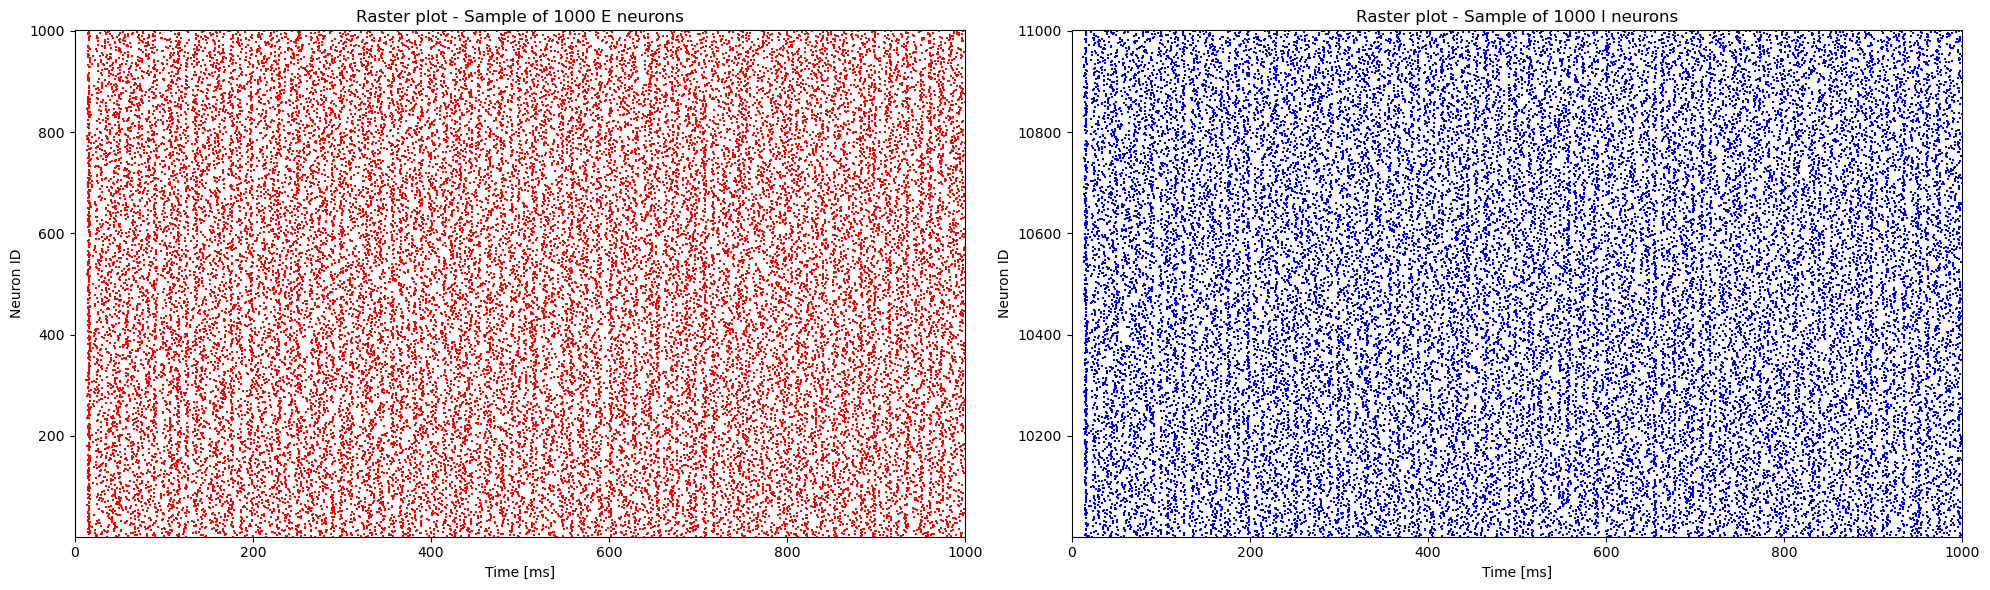

In [14]:
events_E = spike_rec_E.get("events")
times_E = events_E["times"]
senders_E = events_E["senders"]

events_I = spike_rec_I.get("events")
times_I = events_I["times"]
senders_I = events_I["senders"]

fig, ax = plt.subplots(1,2, figsize=(20, 6))
ax[0].scatter(times_E, senders_E, s=2, color='r', marker = '|')
ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Neuron ID")
ax[0].set_title("Raster plot - Sample of 1000 E neurons")
ax[0].set_xlim(0,1000)
ax[0].set_ylim(min(senders_E), max(senders_E)+1)

ax[1].scatter(times_I, senders_I, s=2, color='b', marker = '|')
ax[1].set_xlabel("Time [ms]")
ax[1].set_ylabel("Neuron ID")
ax[1].set_title("Raster plot - Sample of 1000 I neurons")
ax[1].set_xlim(0,1000)
ax[1].set_ylim(min(senders_I), max(senders_I)+1)

plt.tight_layout()
plt.show()

## Network Basic Analysis 

In [15]:
def mean_rate(times, simtime, n_rec=1000):
    """
    Compute mean firing rate from the recorded neurons. 
    """
    return (len(times) / n_rec) / (simtime / 1000.0)

In [16]:
rate_ex = mean_rate(times_E, simtime=1000.)
rate_in = mean_rate(times_I, simtime=1000.)

print(f"Mean excitatory rate: {rate_ex} Hz")
print(f"Mean inhibitory  rate: {rate_in} Hz")

Mean excitatory rate: 31.855 Hz
Mean inhibitory  rate: 31.998 Hz


In [17]:
def compute_cv_isi(spike_times):
    "Compute the coefficient of variation."
    if len(spike_times)<3:
        return np.nan
    isi = np.diff(spike_times) # compute the interspike interval for each couple of spikes
    return np.std(isi)/np.mean(isi)

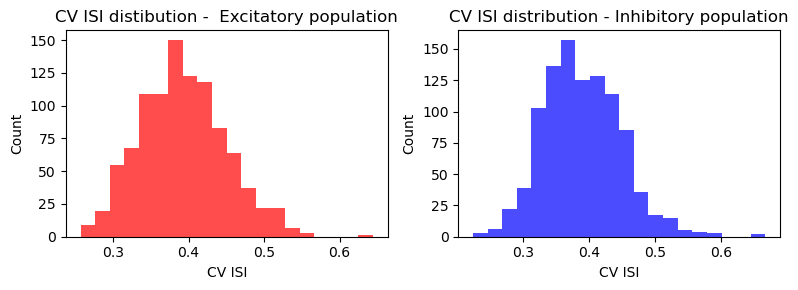

In [18]:
# apply to excitatory pop
cv_E = []
unique_E = np.unique(senders_E)

for neuron_id in unique_E:
    spikes = times_E[senders_E==neuron_id]
    cv = compute_cv_isi(spikes)
    cv_E.append(cv)
cv_E = np.array(cv_E)

# apply to inhibitory population
cv_I = []
unique_I = np.unique(senders_I)

for neuron in unique_I:
    spikes_n = times_I[senders_I == neuron]
    cv = compute_cv_isi(spikes_n)
    cv_I.append(cv)

cv_I = np.array(cv_I)

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.hist(cv_E[~np.isnan(cv_E)], bins=20, alpha=0.7, color='r')
plt.xlabel("CV ISI")
plt.ylabel("Count")
plt.title("CV ISI distibution -  Excitatory population")

plt.subplot(1,2,2)
plt.hist(cv_I[~np.isnan(cv_I)], bins=20, alpha=0.7, color="b")
plt.xlabel("CV ISI")
plt.ylabel("Count")
plt.title("CV ISI distribution - Inhibitory population")

plt.tight_layout()
plt.show()

In [19]:
def compute_firing_rate(times, senders, Tmax=1000, dt=0.1, kernel_width=20.0):
    t_bins = np.arange(0, Tmax, dt)
    rate = np.zeros_like(t_bins)

    indices = (times / dt).astype(int)
    indices = indices[indices < len(rate)]
    for i in indices:
        rate[i] += 1

    N = len(np.unique(senders))
    rate = rate * (1000 / dt) / N

    # Gaussian kernel
    sigma = kernel_width / dt
    kernel_size = int(6 * sigma)
    x = np.linspace(-3*sigma, 3*sigma, kernel_size)
    kernel = np.exp(-0.5 * (x / sigma)**2)
    kernel /= kernel.sum()

    # Smoothed firing rate
    rate  = np.convolve(rate, kernel, mode='same')

    return t_bins, rate

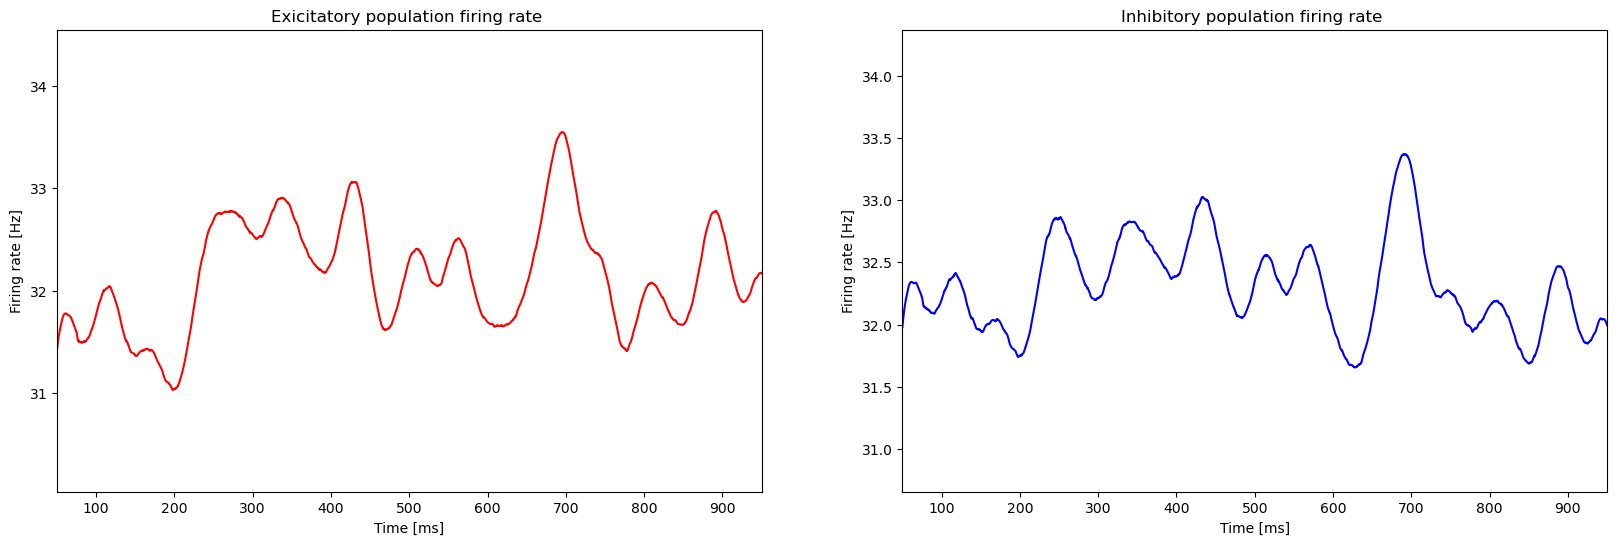

In [20]:
t_bins_E, rate_E = compute_firing_rate(times_E, senders_E)
t_bins_I, rate_I = compute_firing_rate(times_I, senders_I)

fig, ax = plt.subplots(1,2, figsize=(20, 6))
ax[0].plot(t_bins_E, rate_E, color='r')
ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Firing rate [Hz]")
ax[0].set_xlim(50, 950.) # with gaussian kernel the boundaries are always close to 0
ax[0].set_ylim(min(rate_E[500:9500])-1, max(rate_E[500:9500])+1)
ax[0].set_title("Exicitatory population firing rate ")

ax[1].plot(t_bins_I, rate_I, color='b')
ax[1].set_xlabel("Time [ms]")
ax[1].set_ylabel("Firing rate [Hz]")
ax[1].set_xlim(50, 950.) 
ax[1].set_ylim(min(rate_I[500:9500])-1, max(rate_I[500:9500])+1)
ax[1].set_title("Inhibitory population firing rate ")

plt.show()

In [21]:
def simulate_Brunel_network(p_rate, g, NE=10000, NI=2500):
    nest.ResetKernel()
    nest.SetKernelStatus({
    "local_num_threads": 8})

    epsilon = 0.1 
    CE = int(epsilon * NE)
    CI = int(epsilon * NI)
    
    E_neurons = nest.Create("iaf_psc_alpha", NE, params = params)
    I_neurons = nest.Create("iaf_psc_alpha", NI, params = params)
    poisson = nest.Create("poisson_generator", {"rate": p_rate})
    spike_rec_E = nest.Create("spike_recorder")
    spike_rec_I = nest.Create("spike_recorder")
    
    J_exc = 20.
    J_in = -g*J_exc
    
    nest.Connect(poisson, E_neurons, syn_spec={"weight": J_exc, "delay":1.5})
    nest.Connect(poisson, I_neurons, syn_spec={"weight": J_exc, "delay":1.5})
    nest.Connect(E_neurons, E_neurons, conn_spec={'rule': 'fixed_indegree', 'indegree': CE},syn_spec={'weight': J_exc, 'delay':1.5})
    nest.Connect(E_neurons, I_neurons,conn_spec={'rule': 'fixed_indegree', 'indegree': CE},syn_spec={'weight': J_exc, 'delay':1.5})
    nest.Connect(I_neurons, E_neurons,conn_spec={'rule': 'fixed_indegree', 'indegree': CI},syn_spec={'weight': J_in, 'delay':1.5})
    nest.Connect(I_neurons, I_neurons,conn_spec={'rule': 'fixed_indegree', 'indegree': CI},syn_spec={'weight': J_in, 'delay':1.5})

    nest.Connect(E_neurons[:1000], spike_rec_E) 
    nest.Connect(I_neurons[:1000], spike_rec_I) 

    T = 500.
    nest.Simulate(T)
    
    events_E = spike_rec_E.get("events")
    times_E = events_E["times"]
    senders_E = events_E["senders"]
    
    events_I = spike_rec_I.get("events")
    times_I = events_I["times"]
    senders_I = events_I["senders"]

    return times_E, senders_E, times_I, senders_I

In [22]:
def plot_Brunel_network(p_rate,g):
    times_E, senders_E, times_I, senders_I = simulate_Brunel_network(p_rate, g)
    
    rate_ex = mean_rate(times_E, simtime=500.)
    rate_in = mean_rate(times_I, simtime=500.)

    print(f"Mean excitatory rate: {rate_ex} Hz")
    print(f"Mean inhibitory  rate: {rate_in} Hz")

    cv_E = []
    unique_E = np.unique(senders_E)
    
    for neuron_id in unique_E:
        spikes = times_E[senders_E==neuron_id]
        cv = compute_cv_isi(spikes)
        cv_E.append(cv)
    cv_E = np.array(cv_E)
    
    # apply to inhibitory population
    cv_I = []
    unique_I = np.unique(senders_I)
    
    for neuron in unique_I:
        spikes_n = times_I[senders_I == neuron]
        cv = compute_cv_isi(spikes_n)
        cv_I.append(cv)
    
    cv_I = np.array(cv_I)

    t_bins_E, rate_E = compute_firing_rate(times_E, senders_E, Tmax=500, kernel_width=2)
    t_bins_I, rate_I = compute_firing_rate(times_I, senders_I, Tmax=500, kernel_width=2)


    fig, ax = plt.subplots(1,2, figsize=(10, 3))
    ax[0].scatter(times_E, senders_E, s=1, color='r', marker = '|')
    ax[0].set_xlabel("Time [ms]")
    ax[0].set_ylabel("Neuron ID")
    ax[0].set_title("Raster plot - Sample of 1000 E neurons")
    ax[0].set_xlim(300,400)
    ax[0].set_ylim(min(senders_E), max(senders_E)+1)
    
    ax[1].scatter(times_I, senders_I, s=1, color='b', marker = '|')
    ax[1].set_xlabel("Time [ms]")
    ax[1].set_ylabel("Neuron ID")
    ax[1].set_title("Raster plot - Sample of 1000 I neurons")
    ax[1].set_xlim(300,400)
    ax[1].set_ylim(min(senders_I), max(senders_I)+1)
    
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1,2, figsize=(10, 3))
    ax[0].plot(t_bins_E, rate_E, color='r')
    ax[0].set_xlabel("Time [ms]")
    ax[0].set_ylabel("Firing rate [Hz]")
    ax[0].set_xlim(300, 400.) # with gaussian kernel the boundaries are always close to 0
    ax[0].set_ylim(min(rate_E[1000:4500])-1, max(rate_E[1000:4500])+1)
    ax[0].set_title("Exicitatory population firing rate ")
    
    ax[1].plot(t_bins_I, rate_I, color='b')
    ax[1].set_xlabel("Time [ms]")
    ax[1].set_ylabel("Firing rate [Hz]")
    ax[1].set_xlim(300, 400.) 
    ax[1].set_ylim(min(rate_I[1000:4500])-1, max(rate_I[1000:4500])+1)
    ax[1].set_title("Inhibitory population firing rate ")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.hist(cv_E[~np.isnan(cv_E)], bins=20, alpha=0.7, color='r')
    plt.xlabel("CV ISI")
    plt.ylabel("Count")
    plt.title("CV ISI distibution -  Excitatory population")
    
    plt.subplot(1,2,2)
    plt.hist(cv_I[~np.isnan(cv_I)], bins=20, alpha=0.7, color="b")
    plt.xlabel("CV ISI")
    plt.ylabel("Count")
    plt.title("CV ISI distribution - Inhibitory population")
    
    plt.tight_layout()
    plt.show()

In [23]:
_ = widgets.interact(plot_Brunel_network,p_rate=(7000, 20000, 1000), g=(0.,6,0.5))

interactive(children=(IntSlider(value=13000, description='p_rate', max=20000, min=7000, step=1000), FloatSlide…

**Exercise:** try to indentify the regimes of the network reported in the introduction. 